In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from py_experimenter.experimenter import PyExperimenter

# Get Data From DataBase

In [2]:
baseline_config_path = "dynabo/experiments/baseline_experiments/config.yml"
prior_config_path = "dynabo/experiments/prior_experiments/config.yml"
credentials_path = "config/database_credentials.yml"

In [3]:
baseline_experimenter = PyExperimenter(baseline_config_path, credentials_path)
prior_experimenter = PyExperimenter(prior_config_path, credentials_path)

2025-01-20 16:26:12,127  | py-experimenter - INFO     | Found 9 keyfields
2025-01-20 16:26:12,130  | py-experimenter - INFO     | Found 7 resultfields
2025-01-20 16:26:12,131  | py-experimenter - INFO     | Found 1 logtables
2025-01-20 16:26:12,132  | py-experimenter - INFO     | Found logtable baseline__incumbents
2025-01-20 16:26:12,133  | py-experimenter - WARNING  | No custom section defined in config
2025-01-20 16:26:12,134  | py-experimenter - WARNING  | No codecarbon section defined in config
2025-01-20 16:26:12,142  | py-experimenter - INFO     | Initialized and connected to database


2025-01-20 16:26:12,175  | py-experimenter - INFO     | Found 13 keyfields
2025-01-20 16:26:12,177  | py-experimenter - INFO     | Found 7 resultfields
2025-01-20 16:26:12,178  | py-experimenter - INFO     | Found 2 logtables
2025-01-20 16:26:12,179  | py-experimenter - INFO     | Found logtable dynamic_prior_dev__incumbents
2025-01-20 16:26:12,180  | py-experimenter - INFO     | Found logtable dynamic_prior_dev__priors
2025-01-20 16:26:12,180  | py-experimenter - WARNING  | No custom section defined in config
2025-01-20 16:26:12,181  | py-experimenter - WARNING  | No codecarbon section defined in config
2025-01-20 16:26:12,189  | py-experimenter - INFO     | Initialized and connected to database


In [4]:
baseline_incumbent_df = baseline_experimenter.get_logtable("incumbents")
prior_incumbent_df = prior_experimenter.get_logtable("incumbents")
prior_priors_df = prior_experimenter.get_logtable("priors")

In [5]:
baseline_incumbent_df.head()

,ID,experiment_id,timestamp,performance,configuration,after_n_evaluations,after_runtime,after_virtual_runtime,after_reasoning_runtime
0,1,1,2025-01-20 11:08:21,0.822191,"{'min.node.size': 27, 'mtry.power': 0.62056469...",1,31.264,31.266,0.002
1,2,2,2025-01-20 11:08:21,0.829881,"{'min.node.size': 41, 'mtry.power': 0.92743327...",1,110.165,110.167,0.002
2,3,1,2025-01-20 11:08:21,0.831120,"{'min.node.size': 78, 'mtry.power': 0.03243755...",2,46.971,47.318,0.347
3,4,1,2025-01-20 11:08:21,0.833909,"{'min.node.size': 65, 'mtry.power': 0.95718002...",3,117.559,118.074,0.515
4,5,2,2025-01-20 11:08:22,0.833272,"{'min.node.size': 7, 'mtry.power': 0.621135525...",5,210.588,211.464,0.876


In [6]:
prior_priors_df.head()

,ID,experiment_id,timestamp,prior_accepted,performance,configuration,after_n_evaluations,after_runtime,after_virtual_runtime,after_reasoning_runtime
0,1,4,2025-01-20 16:18:14,1,0.855388,"{'min.node.size': 3, 'mtry.power': 0.330893147...",50,957.715,961.232,3.517
1,2,2,2025-01-20 16:18:15,1,0.863989,"{'min.node.size': 1, 'mtry.power': 0.419652317...",50,1620.440,1625.010,4.565
2,3,1,2025-01-20 16:18:16,1,0.864068,"{'min.node.size': 1, 'mtry.power': 0.422882644...",50,950.318,954.964,4.646
3,4,3,2025-01-20 16:18:16,1,0.864276,"{'min.node.size': 1, 'mtry.power': 0.403489448...",50,1009.540,1014.970,5.430
4,5,5,2025-01-20 16:18:17,1,0.863996,"{'min.node.size': 1, 'mtry.power': 0.420304970...",50,1974.400,1980.060,5.658


In [7]:
def find_last(df: pd.DataFrame, experiment_id: int, column: str, current: int):
    last_trial = df[(df["experiment_id"] == experiment_id) & (df[column] < current)]
    if len(last_trial) == 0:
        raise ValueError("No previous trial found")
    else:
        last_column_value = df[(df["experiment_id"] == experiment_id) & (df[column] < current)][column].max()
        df = df[(df["experiment_id"] == experiment_id) & (df[column] == last_column_value)]
        return df


def fill_df(iterator_df: pd.DataFrame, max_trials=200, x_axis_column: str = "after_n_evaluations"):
    rows = []
    for n_trials in sorted(iterator_df["after_n_evaluations"].unique()):
        if n_trials == 1:
            relevant_df = iterator_df[iterator_df["after_n_evaluations"] == n_trials]
            after_n_evaluations = n_trials
            after_runtime = relevant_df["after_runtime"].max()
            after_virtual_runtime = relevant_df["after_virtual_runtime"].max()
            after_reasoning_runtime = relevant_df["after_reasoning_runtime"].max()
            avg_performance = relevant_df["performance"].mean()
            std_performance = relevant_df["performance"].std()
            percentile_upper = np.percentile(relevant_df["performance"], 95)
            percentile_lower = np.percentile(relevant_df["performance"], 5)
            rows.append([after_n_evaluations, after_runtime, after_virtual_runtime, after_reasoning_runtime, avg_performance, std_performance, percentile_upper, percentile_lower])
        else:
            # Find row of last incumbent for each of the experiment_ids
            last_incumbent_rows = []
            for experiment_id in iterator_df["experiment_id"].unique():
                last = find_last(iterator_df, experiment_id, x_axis_column, n_trials)
                last_incumbent_rows.append(last)
            last_incumbent_df = pd.concat(last_incumbent_rows)
            after_n_evaluations = n_trials
            after_runtime = last_incumbent_df["after_runtime"].max()
            after_virtual_runtime = last_incumbent_df["after_virtual_runtime"].max()
            after_reasoning_runtime = last_incumbent_df["after_reasoning_runtime"].max()
            avg_performance = last_incumbent_df["performance"].mean()
            std_performance = last_incumbent_df["performance"].std()
            percentile_upper = np.percentile(last_incumbent_df["performance"], 95)
            percentile_lower = np.percentile(last_incumbent_df["performance"], 5)
            rows.append([after_n_evaluations, after_runtime, after_virtual_runtime, after_reasoning_runtime, avg_performance, std_performance, percentile_upper, percentile_lower])

    new_df = pd.DataFrame(
        rows, columns=["after_n_evaluations", "after_runtime", "after_virtual_runtime", "after_reasoning_runtime", "avg_performance", "std_performance", "percentile_upper", "percentile_lower"]
    )
    return new_df

In [8]:
def get_priors(priors_df: pd.DataFrame):
    prior_priors_df = pd.DataFrame(columns=["n_trials", "avg_performance", "percentile_upper", "percentile_lower"])
    priors = []
    for n_trials in sorted(priors_df["after_n_evaluations"].unique()):
        relevant_df = priors_df[priors_df["after_n_evaluations"] == n_trials]
        avg_performance = relevant_df["performance"].mean()
        percentile_upper = np.percentile(relevant_df["performance"], 95)
        percentile_lower = np.percentile(relevant_df["performance"], 5)
        priors.append([n_trials, avg_performance, percentile_upper, percentile_lower])
    prior_priors_df = pd.DataFrame(priors, columns=["n_trials", "avg_performance", "percentile_upper", "percentile_lower"])
    return prior_priors_df

In [9]:
new_df_baseline = fill_df(baseline_incumbent_df)
new_df_prior = fill_df(prior_incumbent_df)
prior_priors_df = get_priors(prior_priors_df)

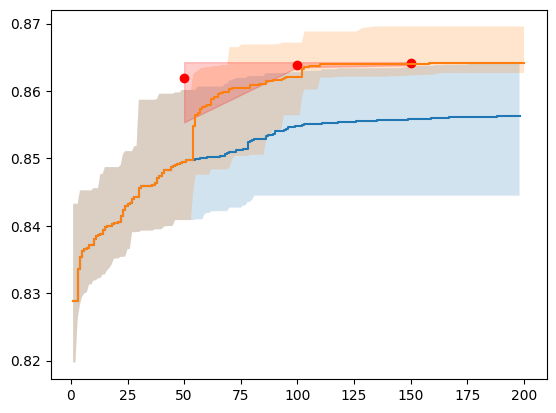

In [10]:
plt.step(new_df_baseline["after_n_evaluations"], new_df_baseline["avg_performance"], where="post", label="Baseline")
plt.fill_between(new_df_baseline["after_n_evaluations"], new_df_baseline["percentile_lower"], new_df_baseline["percentile_upper"], alpha=0.2)
plt.step(new_df_prior["after_n_evaluations"], new_df_prior["avg_performance"], where="post", label="Prior")
plt.fill_between(new_df_prior["after_n_evaluations"], new_df_prior["percentile_lower"], new_df_prior["percentile_upper"], alpha=0.2)
plt.scatter(prior_priors_df["n_trials"], prior_priors_df["avg_performance"], label="Priors", color="red")
plt.fill_between(prior_priors_df["n_trials"], prior_priors_df["percentile_lower"], prior_priors_df["percentile_upper"], alpha=0.2, color="red")